In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from math import sqrt

In [51]:
train = pd.read_csv("../data/schemas/warm_up/TrainSet.csv", sep=",")
validation = pd.read_csv("../data/schemas/warm_up/ValidationSet.csv", sep=",")
test = pd.read_csv("../data/schemas/warm_up/TestSet.csv", sep=",")

In [52]:
# Global variables

NUM_OF_TIMESTEPS_INPUT = 48
NUM_OF_TIMESTEPS_OUTPUT = 24

THRESHOLD = 0.4   # For feature selection

In [53]:
columns_to_predict = ["kg_CO2/kWh", "Avg solar generation"]

independent_variables = []

for column in train:
    if abs(train[column].corr(train[columns_to_predict[0]])) > THRESHOLD: #or abs(train[column].corr(train[columns_to_predict[1]])) > THRESHOLD:
        independent_variables.append(column)

independent_variables = [var for var in independent_variables if var not in columns_to_predict]
    
if "Index" in independent_variables:
    independent_variables.remove("Index")
if "Solar Generation (W/kW)_1" in independent_variables:
    independent_variables.remove("Solar Generation (W/kW)_1")
if "Solar Generation (W/kW)_2" in independent_variables:
    independent_variables.remove("Solar Generation (W/kW)_2")
if "Solar Generation (W/kW)_3" in independent_variables:
    independent_variables.remove("Solar Generation (W/kW)_3")
if "Hour_2" in independent_variables:
    independent_variables.remove("Hour_2")
if "Hour_3" in independent_variables:
    independent_variables.remove("Hour_3")
    

for i in independent_variables:
    print(f"{i}, corr: {'%.3f' % abs(train[i].corr(train[columns_to_predict[0]]))}")

Hour_1, corr: 0.432
Occupant Count (people)_3, corr: 0.458
12h Outdoor Drybulb Temperature (C), corr: 0.605
24h Outdoor Drybulb Temperature (C), corr: 0.401
12h Outdoor Relative Humidity (%), corr: 0.525
6h Direct Solar Radiation (W/m2), corr: 0.532
12h Direct Solar Radiation (W/m2), corr: 0.415


Prepare the data

In [54]:
# Split the X and Y for all sets

# Train set
X_train_default = train[independent_variables]
Y_train_default = train[columns_to_predict]

# Validation set, also include the data from train that was used only as output to get more datapoints
X_val_default = pd.concat([X_train_default.tail(NUM_OF_TIMESTEPS_OUTPUT), validation[independent_variables]], ignore_index=True)
Y_val_default = pd.concat([Y_train_default.tail(NUM_OF_TIMESTEPS_OUTPUT), validation[columns_to_predict]], ignore_index=True)

# Test set, also include the data from train that was used only as output to get more datapoints
X_test_default = pd.concat([X_val_default.tail(NUM_OF_TIMESTEPS_OUTPUT), test[independent_variables]], ignore_index=True)
Y_test_default = pd.concat([Y_val_default.tail(NUM_OF_TIMESTEPS_OUTPUT), test[columns_to_predict]], ignore_index=True)

NUM_OF_ROWS_TRAIN, NUM_OF_FEATURES = X_train_default.shape

print(X_train_default.shape)
print(X_val_default.shape)
print(X_test_default.shape)

(576, 7)
(96, 7)
(96, 7)


In [55]:
# Function to prepare the data into batches that will be passed into the model

def create_sequences(input_data, output_data, timesteps_input, timesteps_output):
    sequences, targets = [], []
    for i in range(len(input_data) - timesteps_input - timesteps_output + 1):
        seq = input_data[i:i + timesteps_input]
        target = output_data[i + timesteps_input: i + timesteps_input + timesteps_output]
        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

In [56]:
X_train, Y_train = create_sequences(X_train_default, Y_train_default, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)
X_val, Y_val = create_sequences(X_val_default, Y_val_default, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)
X_test, Y_test = create_sequences(X_test_default, Y_test_default, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)

print(f"X_train = {X_train.shape}, Y_train = {Y_train.shape}\n"
      f"X_val = {X_val.shape}, Y_val = {Y_val.shape}\n"
      f"X_test = {X_test.shape}, Y_test = {Y_test.shape}")

X_train = (505, 48, 7), Y_train = (505, 24, 2)
X_val = (25, 48, 7), Y_val = (25, 24, 2)
X_test = (25, 48, 7), Y_test = (25, 24, 2)


In [57]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import layers, models
import time

tscv = TimeSeriesSplit(n_splits = 4, test_size=NUM_OF_TIMESTEPS_OUTPUT) # For cross-validation

callback = keras.callbacks.EarlyStopping(monitor='loss', patience = 4) #patience parameter to be adjusted

loss = []
val_loss = []
loss_1 = []
val_loss_1 = []
loss_2 = []
val_loss_2 = []

# Input layer
input_layer = layers.Input(shape=(NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))

# Permute layer
permute_layer = layers.Permute((2, 1))(input_layer)

# Flatten layer
flatten_layer = layers.Flatten()(permute_layer)

# Dense layers for variable 1
dense1 = layers.Dense(192, activation='leaky_relu')(flatten_layer)
dense2 = layers.Dense(96, activation='leaky_relu')(dense1)
dense3 = layers.Dense(48, activation='leaky_relu')(dense2)
output_variable1 = layers.Dense(24, name='output_variable1')(dense3)

# Dense layers for variable 2
dense4 = layers.Dense(192, activation='leaky_relu')(flatten_layer)
dense5 = layers.Dense(96, activation='leaky_relu')(dense4)
dense6 = layers.Dense(48, activation='leaky_relu')(dense5)
output_variable2 = layers.Dense(24, name='output_variable2')(dense6)

# Define the model
model = models.Model(inputs=input_layer, outputs=[output_variable1, output_variable2])

model.compile(
    optimizer='adam',
    loss={'output_variable1': 'mean_squared_error', 'output_variable2': 'mean_squared_error'}
) #types of optimizer, loss function to be adjusted
    

start = time.time()
    
for train_data, test_data in tscv.split(X_train):
    X_train_current_split, X_test_current_split = X_train[train_data], X_train[test_data]
    y_train_current_split, y_test_current_split = Y_train[train_data], Y_train[test_data]
    
    history = model.fit(X_train_current_split, y={"output_variable1": y_train_current_split[:, :, 0], 
                                                  "output_variable2": y_train_current_split[:, :, 1]},
              epochs=100, 
              validation_data=(
                  X_test_current_split,
                {
                    "output_variable1": y_test_current_split[:, :, 0],
                    "output_variable2": y_test_current_split[:, :, 1],
                },
              ),
              # validation_split = 0.8,
              verbose=1,
              callbacks=callback
    )
    loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])
    
    loss_1.append(model.history.history['output_variable1_loss'])
    val_loss_1.append(model.history.history['val_output_variable1_loss'])
    
    loss_2.append(model.history.history['output_variable2_loss'])
    val_loss_2.append(model.history.history['val_output_variable2_loss'])

end = time.time()

print(f"Training time = {end - start} seconds")

Epoch 1/100
13/13 [==============================] - 3s 36ms/step - loss: 0.2686 - output_variable1_loss: 0.1785 - output_variable2_loss: 0.0901 - val_loss: 0.3081 - val_output_variable1_loss: 0.2716 - val_output_variable2_loss: 0.0364
Epoch 2/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0775 - output_variable1_loss: 0.0478 - output_variable2_loss: 0.0297 - val_loss: 0.2075 - val_output_variable1_loss: 0.1824 - val_output_variable2_loss: 0.0252
Epoch 3/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0542 - output_variable1_loss: 0.0366 - output_variable2_loss: 0.0176 - val_loss: 0.1643 - val_output_variable1_loss: 0.1450 - val_output_variable2_loss: 0.0193
Epoch 4/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0433 - output_variable1_loss: 0.0310 - output_variable2_loss: 0.0123 - val_loss: 0.1150 - val_output_variable1_loss: 0.0993 - val_output_variable2_loss: 0.0157
Epoch 5/100
13/13 [==============================] - 0s 8ms

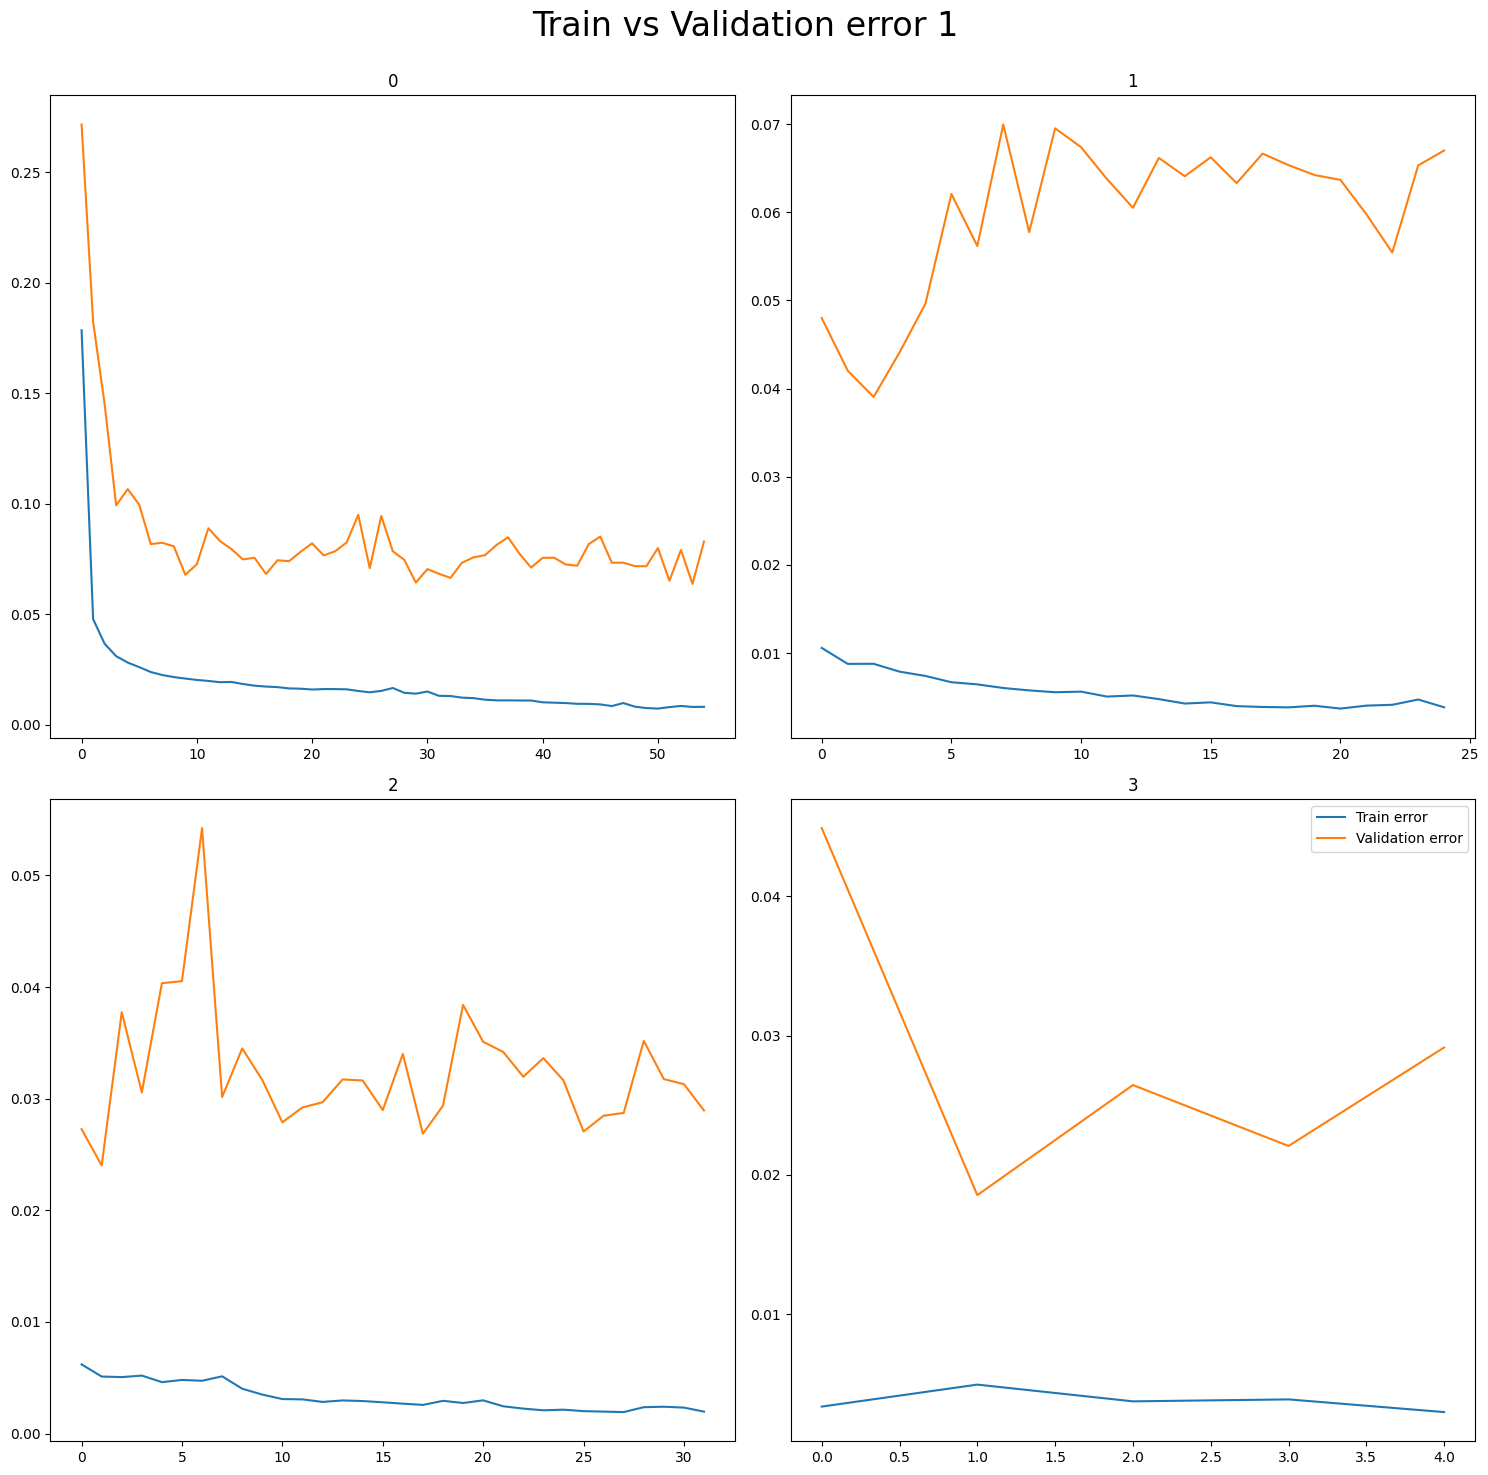

In [58]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

for i, column in enumerate(loss_1):
    ax = axs[i]
    ax.plot(column, label="Train error")
    ax.plot(val_loss_1[i], label="Validation error")
    ax.title.set_text(i)
    
fig.suptitle("Train vs Validation error 1", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

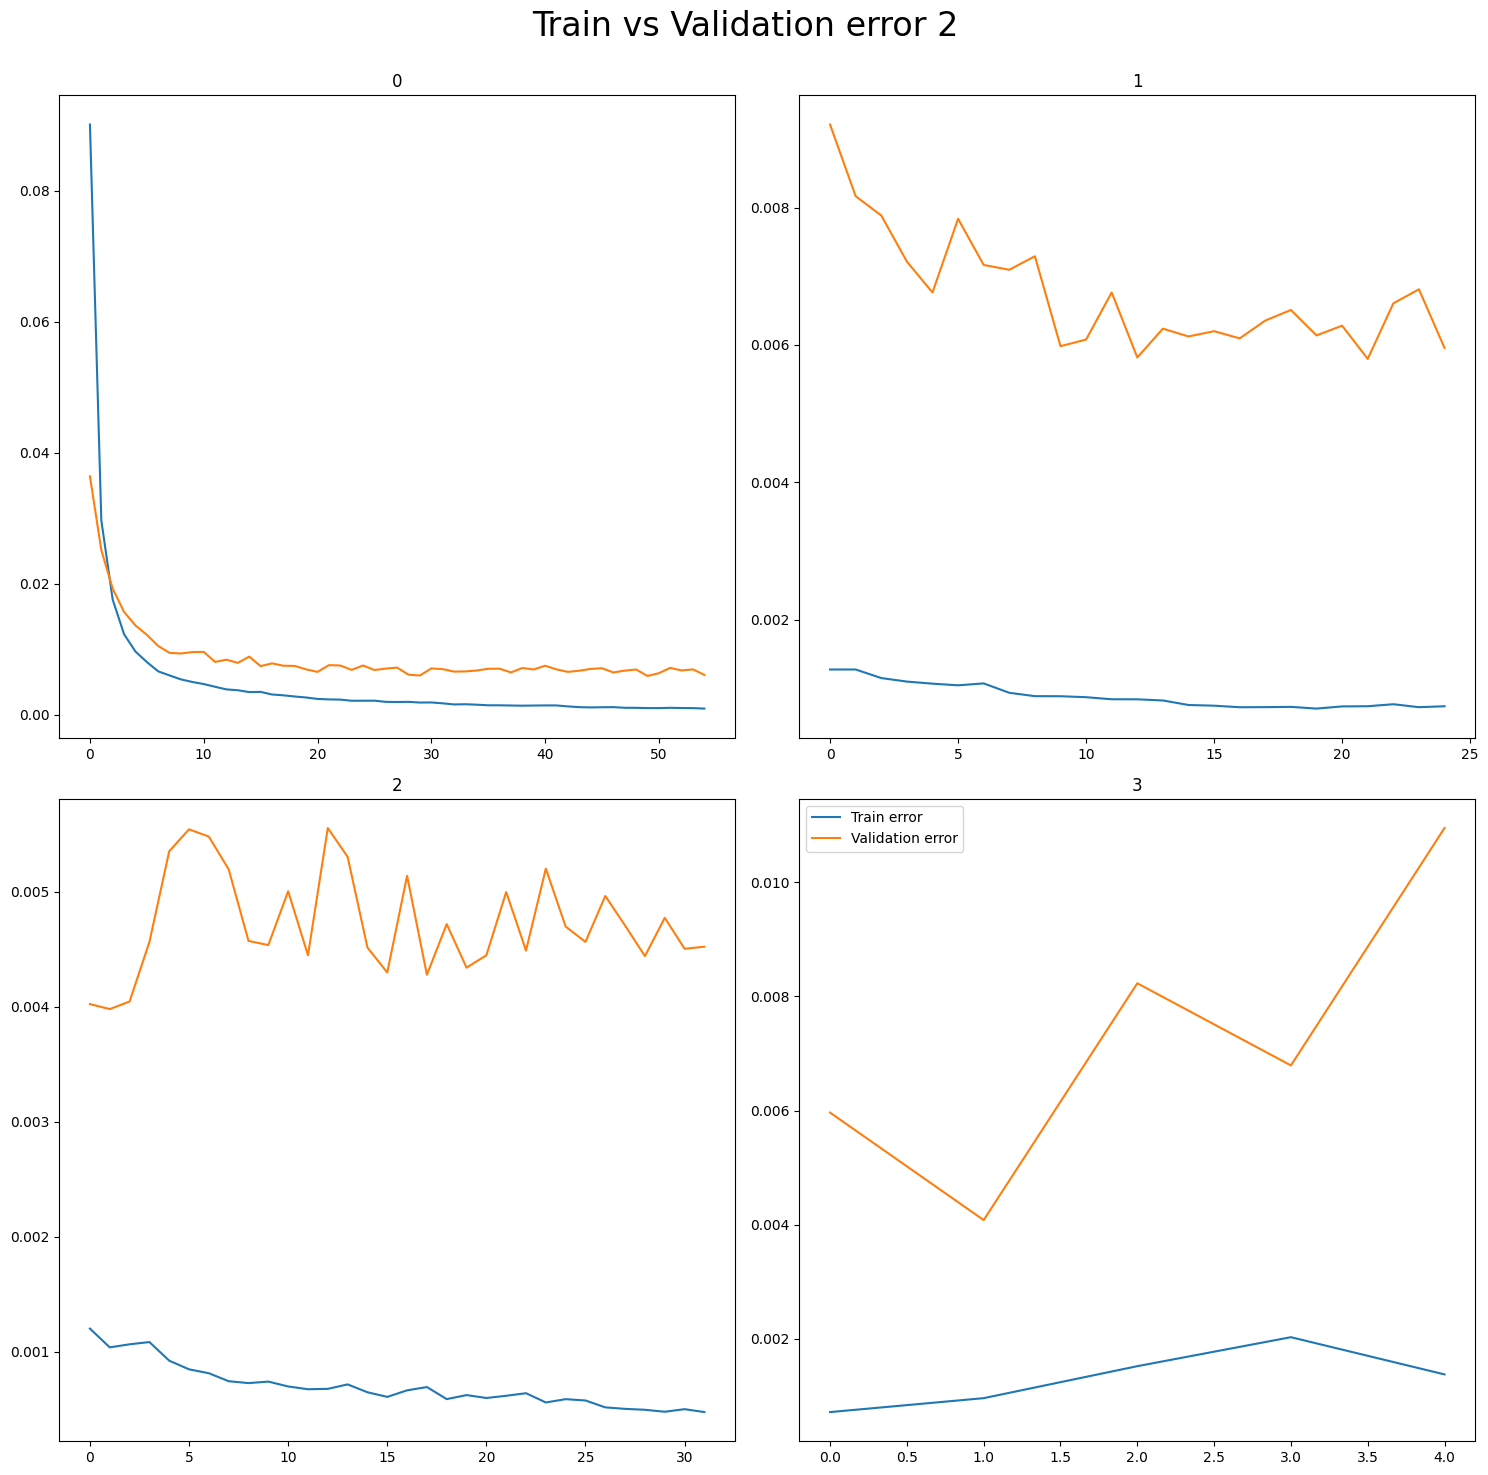

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

for i, column in enumerate(loss_2):
    ax = axs[i]
    ax.plot(column, label="Train error")
    ax.plot(val_loss_2[i], label="Validation error")
    ax.title.set_text(i)
    
fig.suptitle("Train vs Validation error 2", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

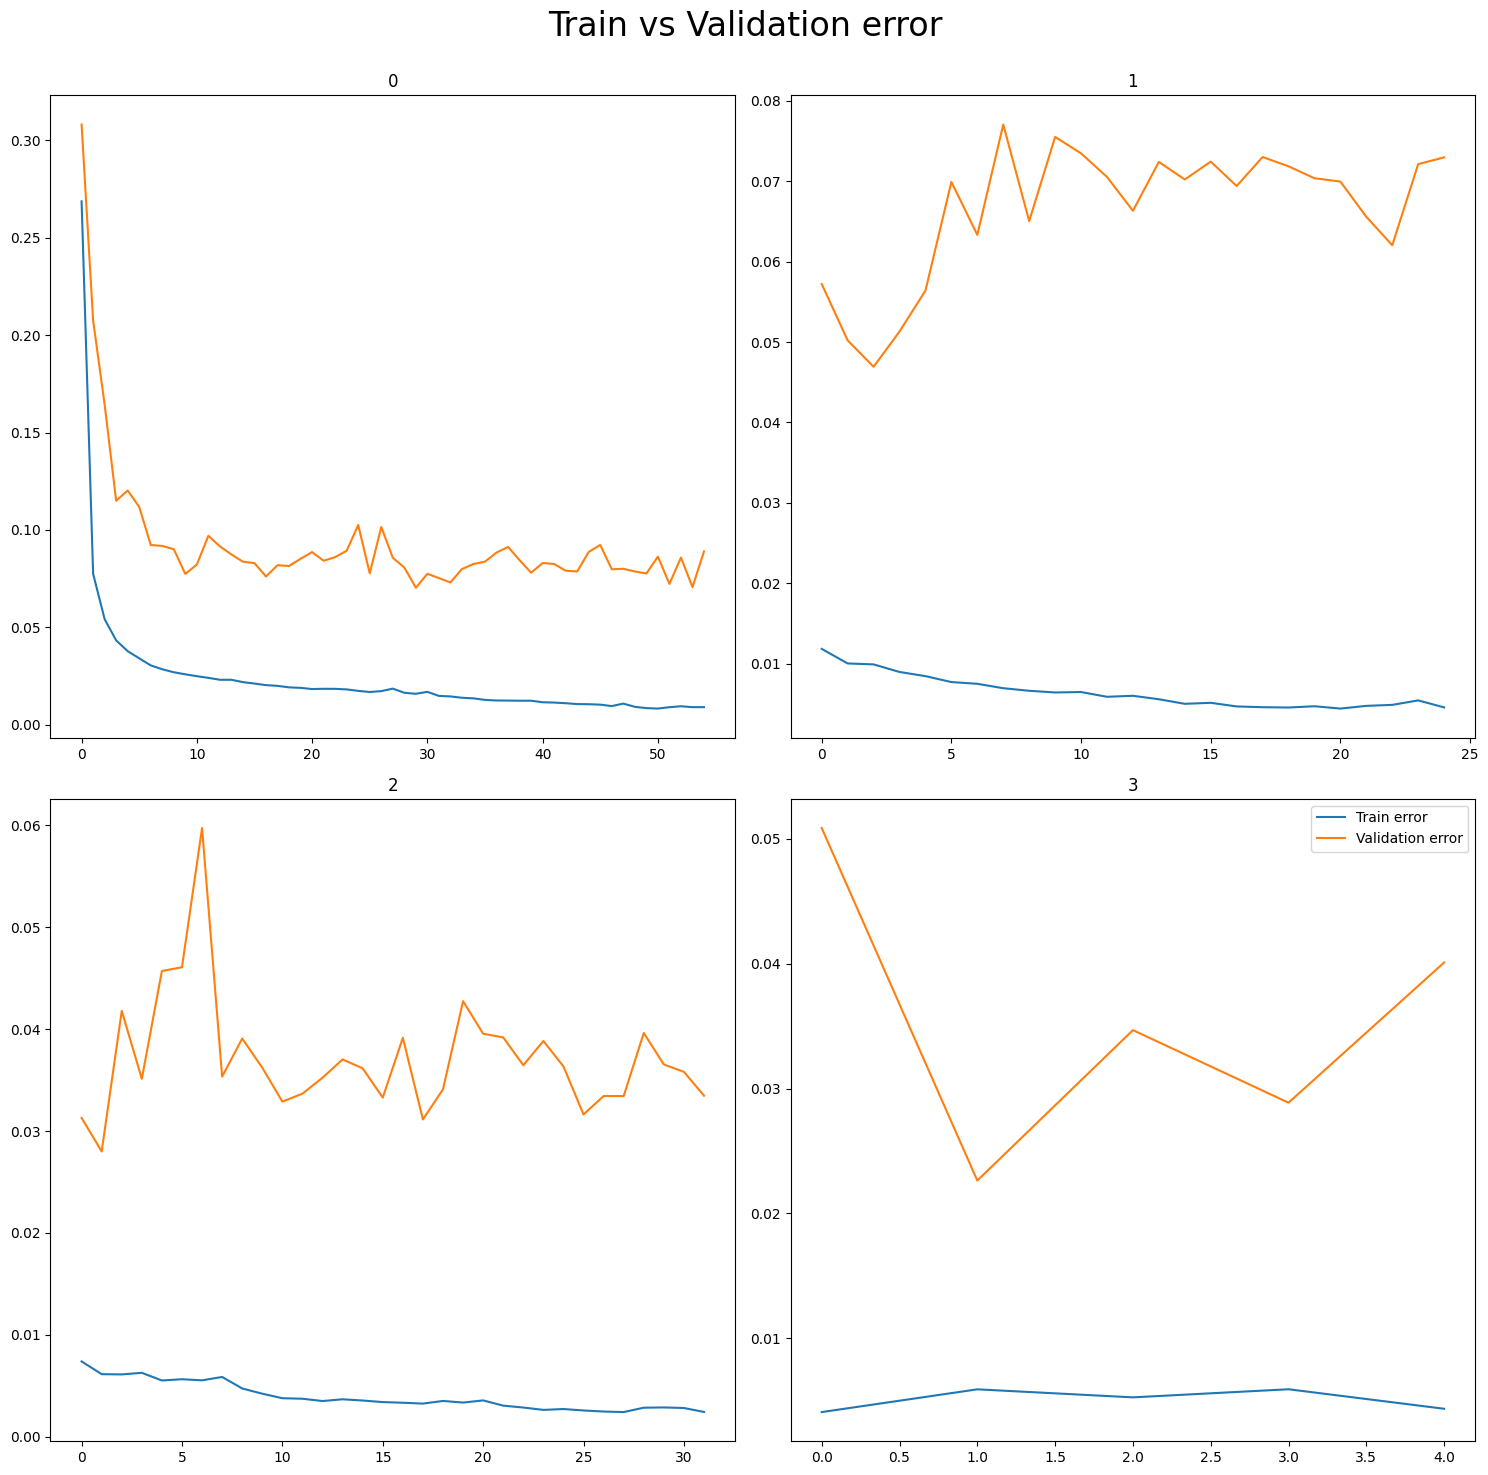

In [60]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

for i, column in enumerate(loss):
    ax = axs[i]
    ax.plot(column, label="Train error")
    ax.plot(val_loss[i], label="Validation error")
    ax.title.set_text(i)
    
fig.suptitle("Train vs Validation error", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

In [61]:
# Evaluate the model on the test data
predictions_1 = []
predictions_2 = []
#print(len(eval_target_variables))

for i in range(len(Y_val)):
    current_batch = X_val[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))
    curr_pred1, curr_pred2 = model.predict(current_batch)
    predictions_1.append(curr_pred1)
    predictions_2.append(curr_pred2)

1/1 [==============================] - 0s 32ms/step


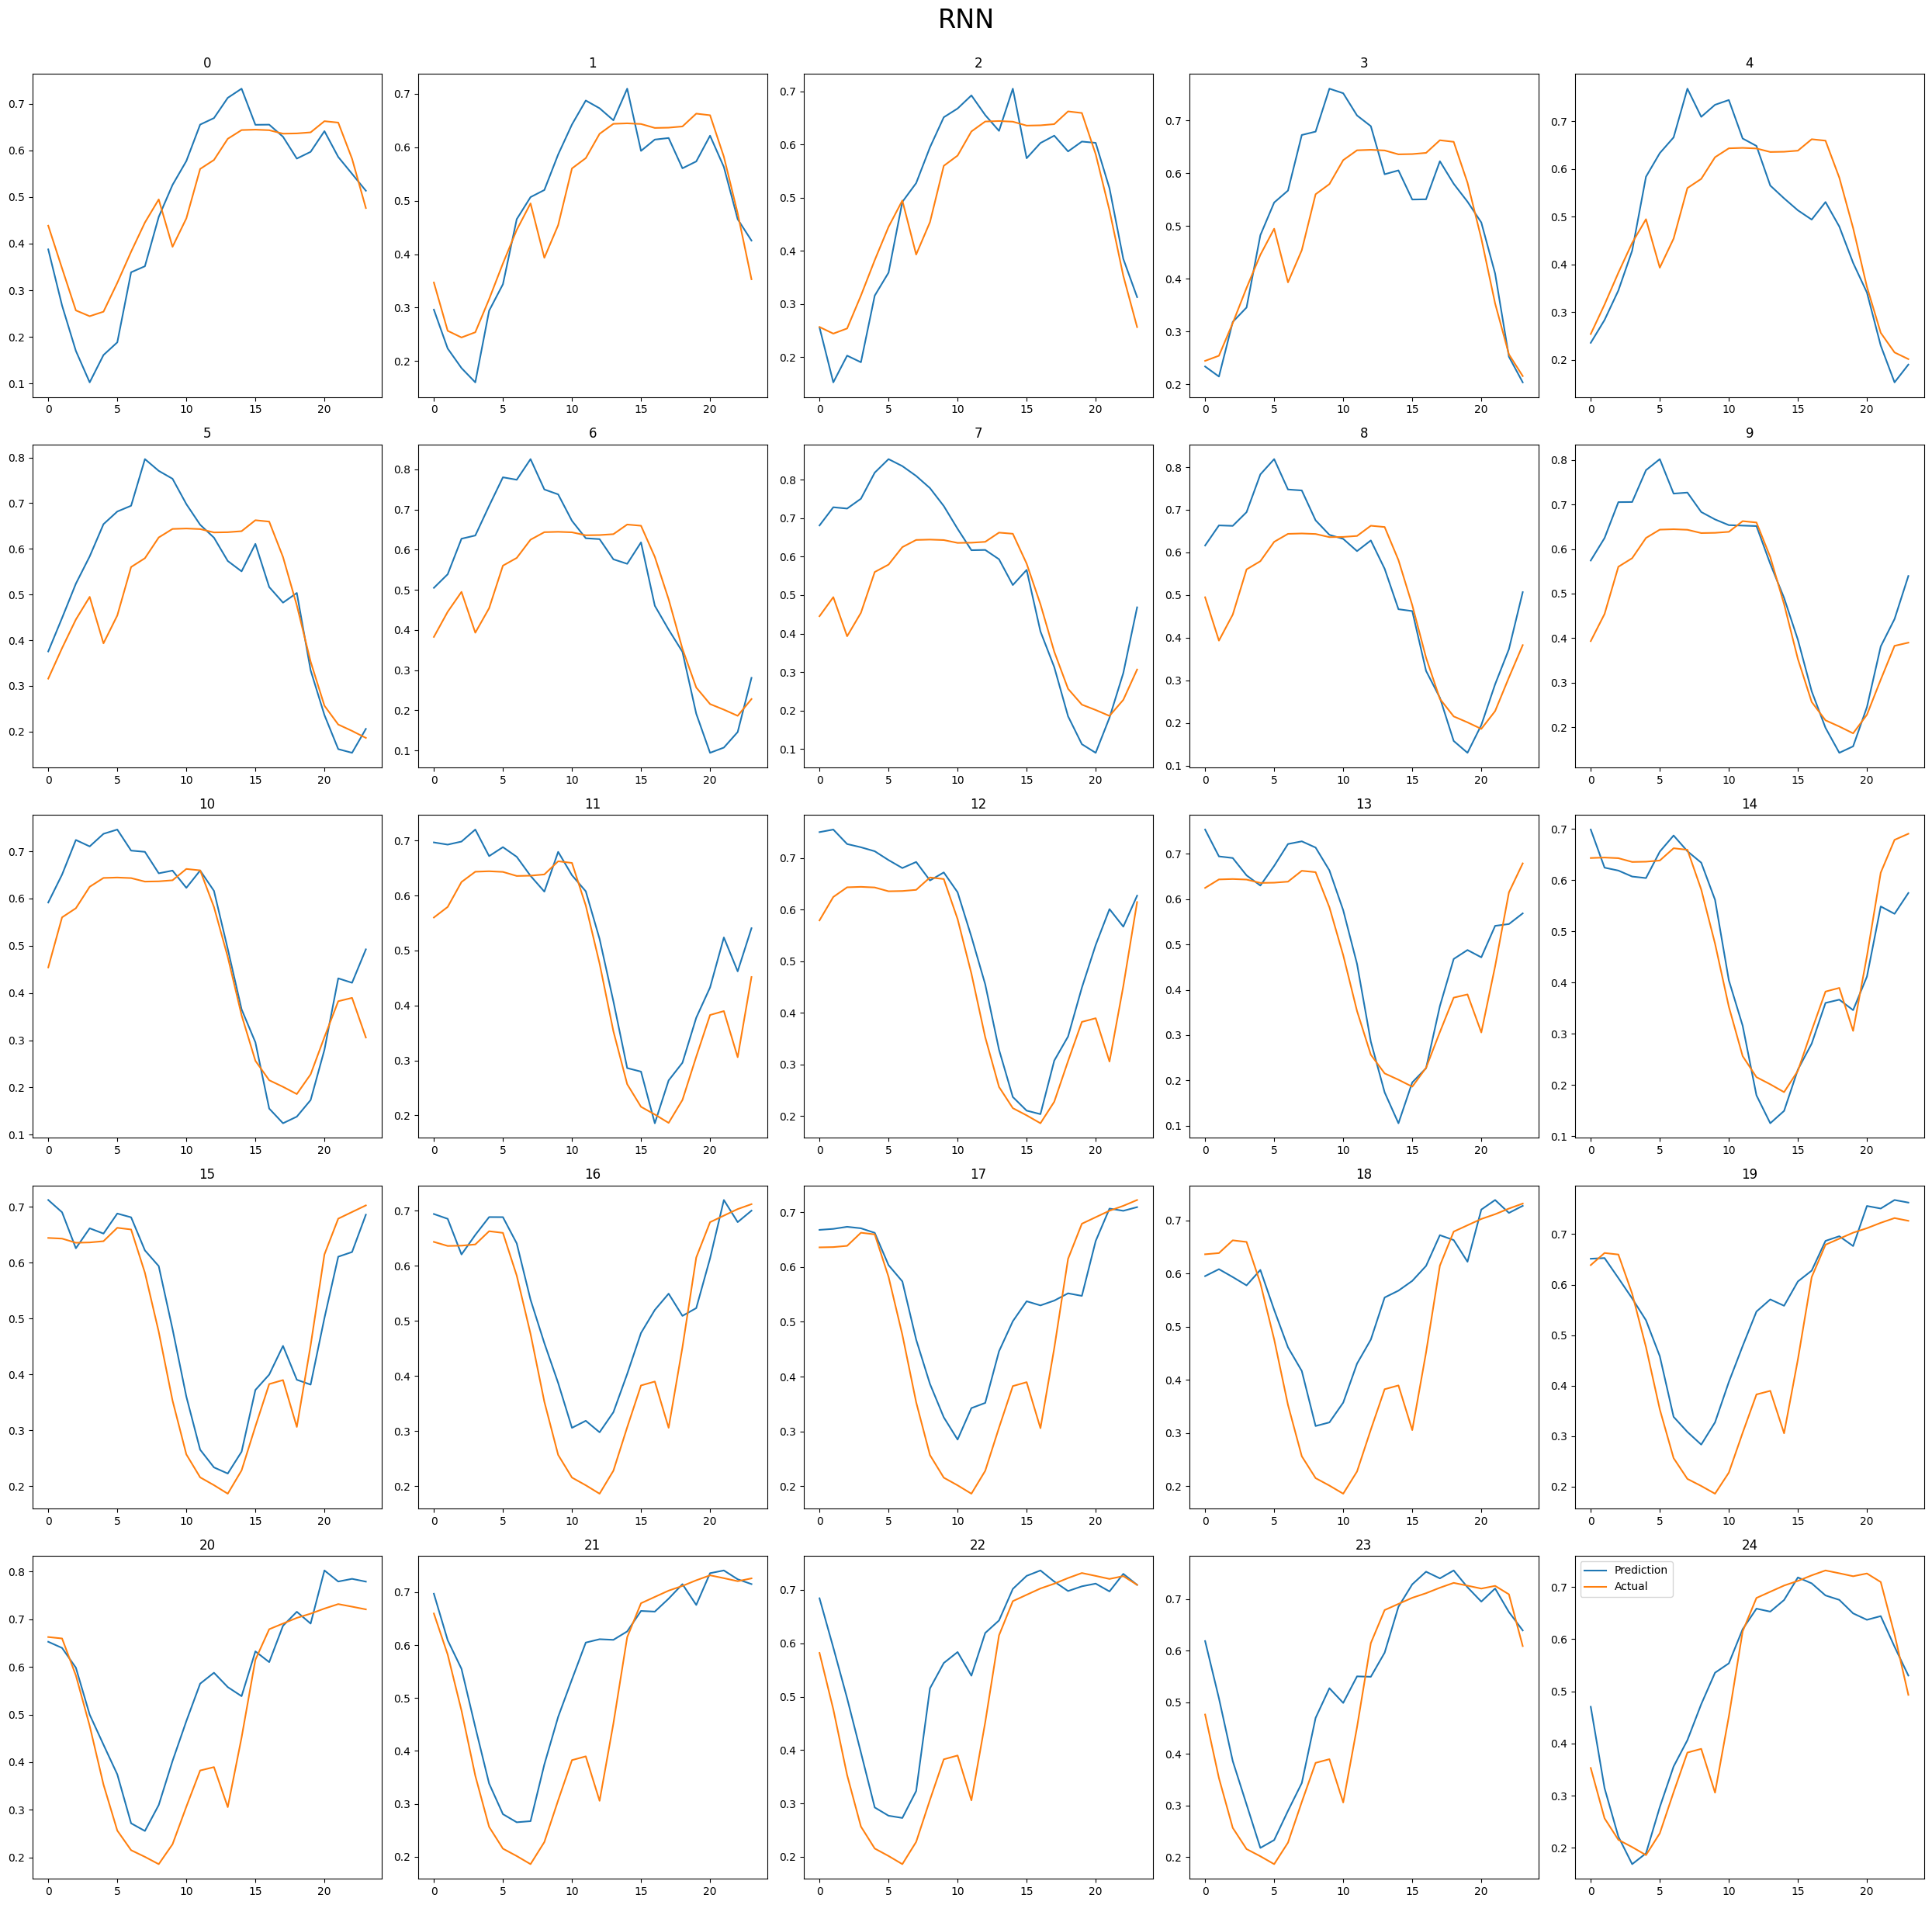

In [62]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i, column in enumerate(predictions_1):
    ax = axs[i]
    ax.plot(column[0], label="Prediction")
    ax.plot(Y_val[i, :, 0], label="Actual")
    ax.title.set_text(i)

fig.suptitle("RNN", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

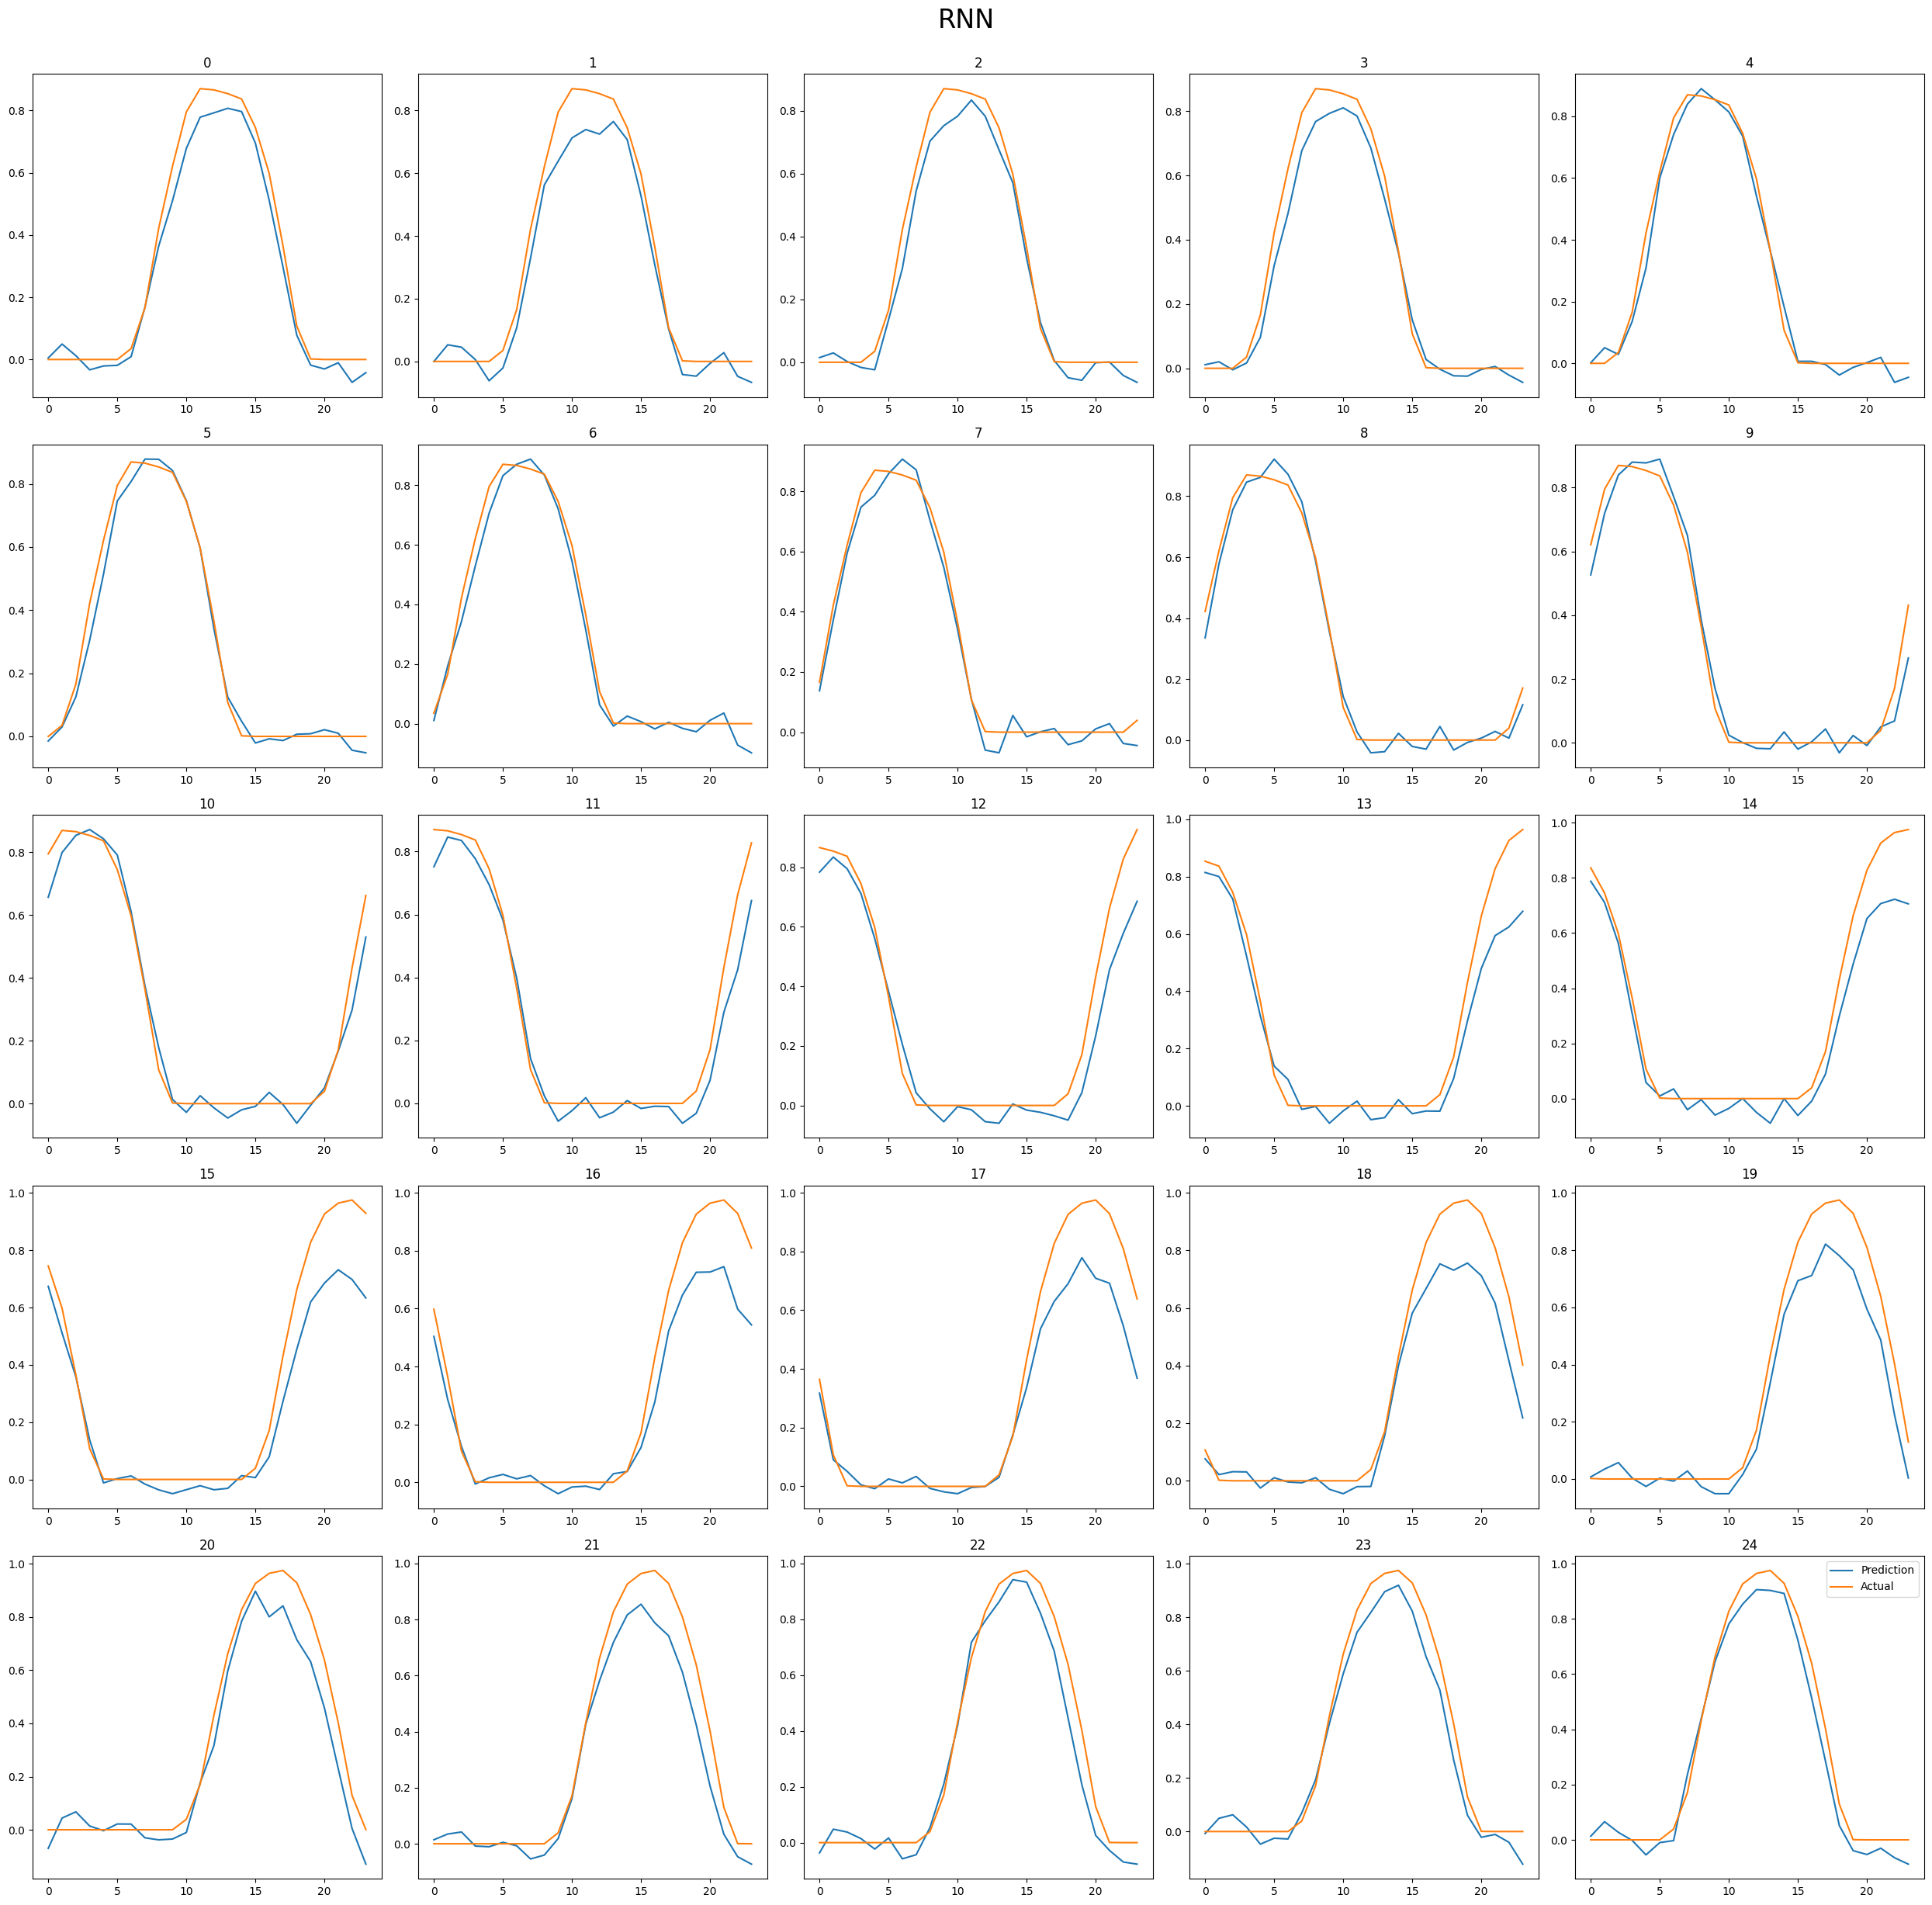

In [63]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i, column in enumerate(predictions_2):
    ax = axs[i]
    ax.plot(column[0], label="Prediction")
    ax.plot(Y_val[i, :, 1], label="Actual")
    ax.title.set_text(i)

fig.suptitle("RNN", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

In [64]:
rmse = 0
for i in range(len(predictions_1)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))}')
    rmse += sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))

rmse /= len(predictions_1)    
print(f"RMSE for {columns_to_predict[0]} = {rmse}")

rmse = 0
for i in range(len(predictions_2)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))}')
    rmse += sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))

rmse /= len(predictions_2)    
print(f"RMSE for {columns_to_predict[1]} = {rmse}")

RMSE for kg_CO2/kWh = 0.0946048648163998
RMSE for Avg solar generation = 0.0815249332646914


In [65]:
# Evaluate the model on the test data
predictions_1_test = []
predictions_2_test = []
#print(len(eval_target_variables))

for i in range(len(Y_test)):
    current_batch = X_test[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))
    curr_pred1, curr_pred2 = model.predict(current_batch)
    predictions_1_test.append(curr_pred1)
    predictions_2_test.append(curr_pred2)

1/1 [==============================] - 0s 32ms/step


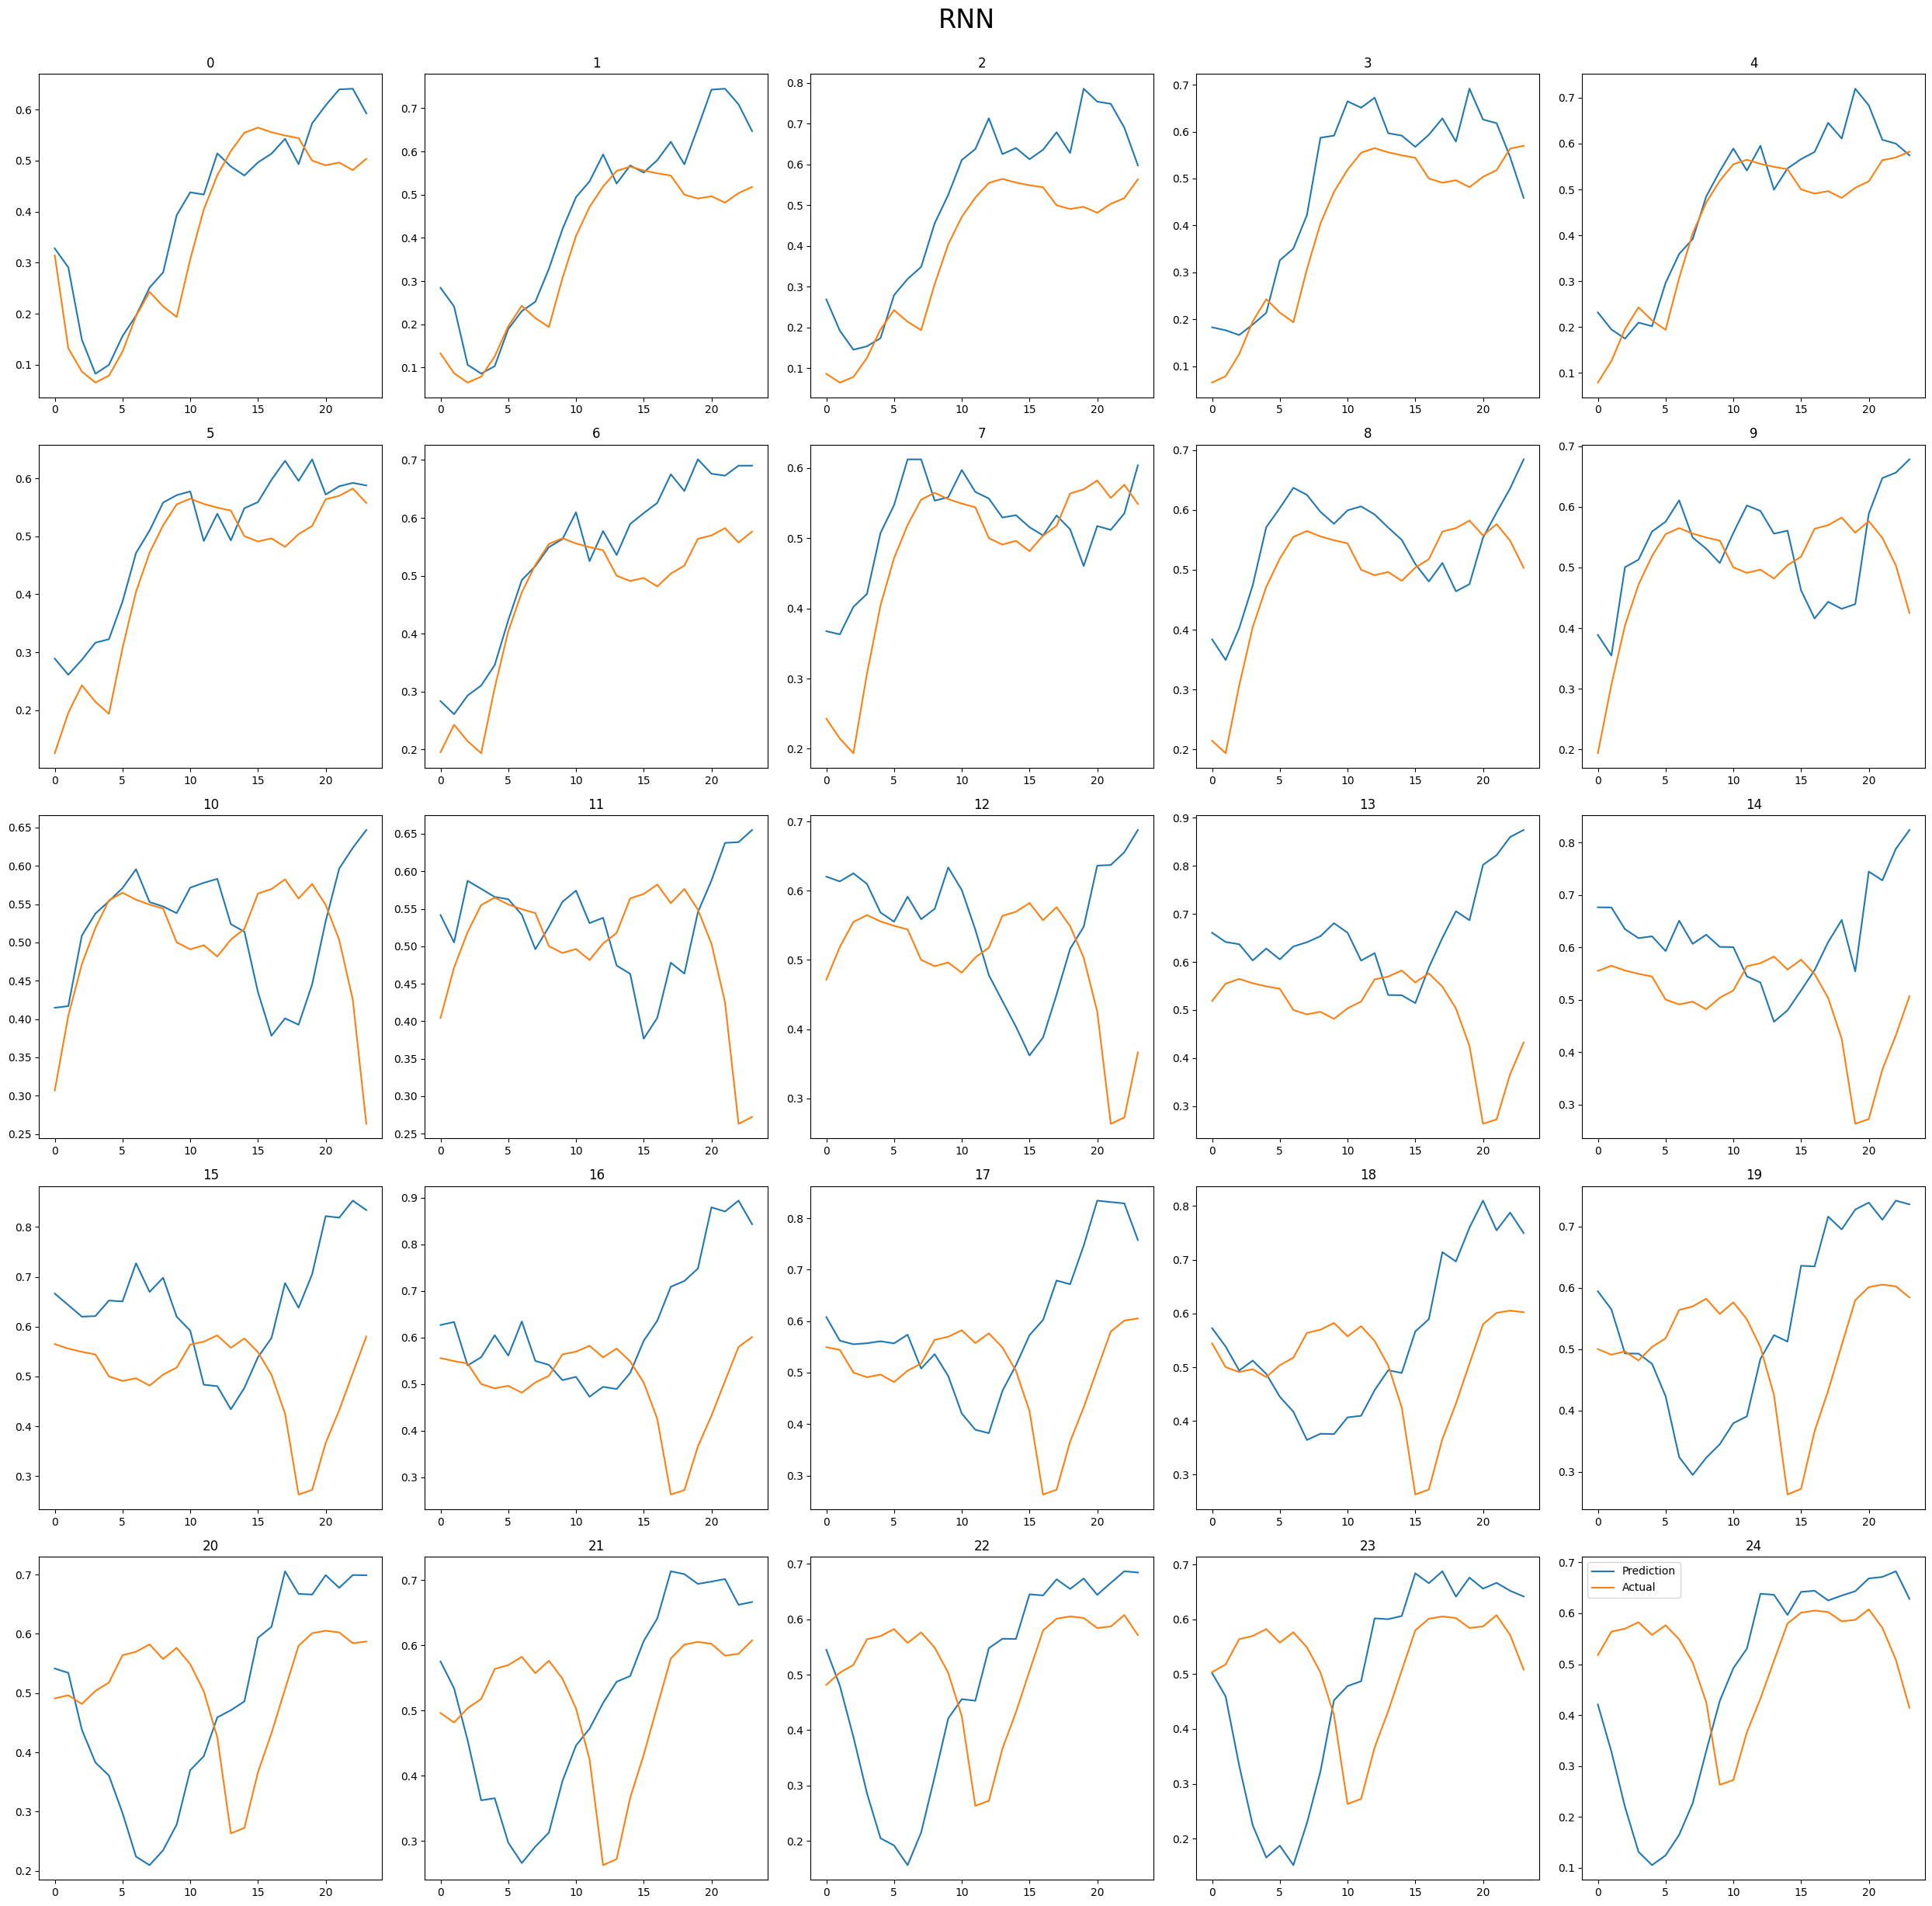

In [66]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i, column in enumerate(predictions_1_test):
    ax = axs[i]
    ax.plot(column[0], label="Prediction")
    ax.plot(Y_test[i, :, 0], label="Actual")
    ax.title.set_text(i)

fig.suptitle("RNN", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

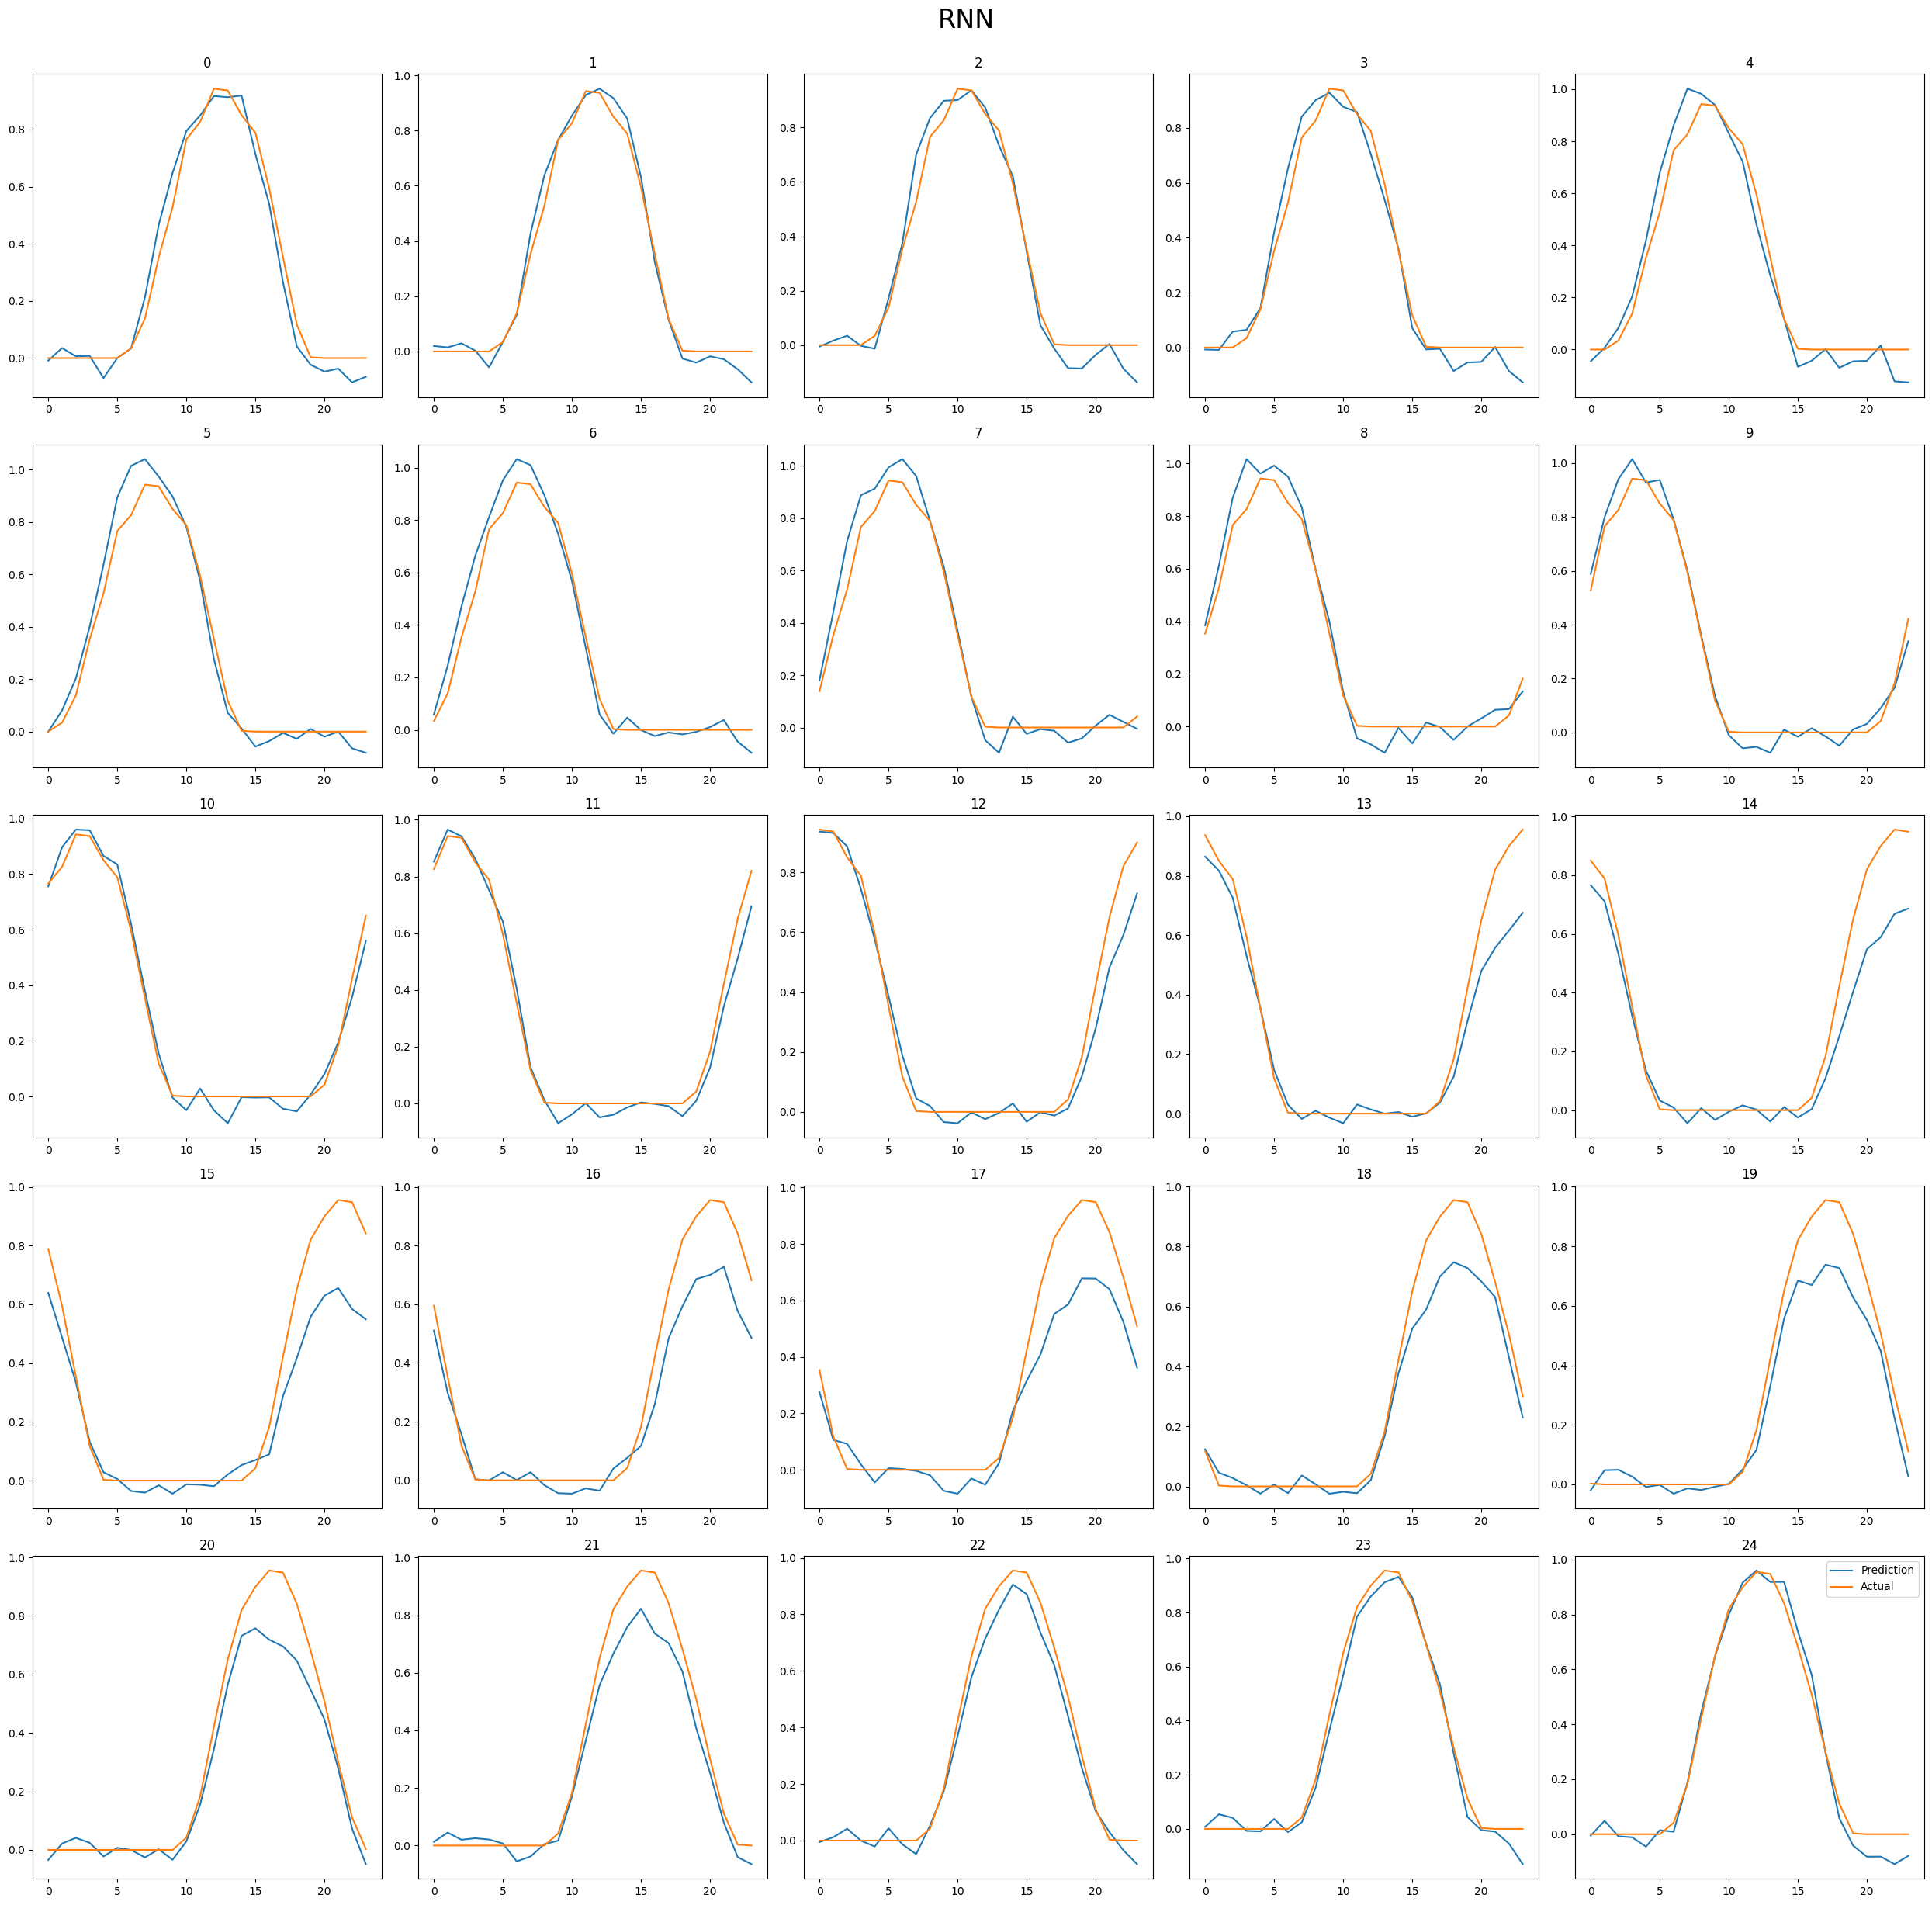

In [67]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i, column in enumerate(predictions_2_test):
    ax = axs[i]
    ax.plot(column[0], label="Prediction")
    ax.plot(Y_test[i, :, 1], label="Actual")
    ax.title.set_text(i)

fig.suptitle("RNN", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

In [68]:
rmse = 0
for i in range(len(predictions_1_test)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))}')
    rmse += sqrt(mean_squared_error(predictions_1_test[i][0], Y_test[i, :, 0]))

rmse /= len(predictions_1_test)    
print(f"RMSE for {columns_to_predict[0]} = {rmse}")

rmse = 0
for i in range(len(predictions_2_test)):
    #print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))}')
    rmse += sqrt(mean_squared_error(predictions_2_test[i][0], Y_test[i, :, 1]))

rmse /= len(predictions_2_test)    
print(f"RMSE for {columns_to_predict[1]} = {rmse}")

RMSE for kg_CO2/kWh = 0.1542646674029513
RMSE for Avg solar generation = 0.08071168183962955


In [69]:
import pydot
import graphviz

#dot_img_file = '/tmp/model_1.png'
#keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

In [73]:
a = []
for column in predictions_1_test:
    a.append(column[0])
    
b = []
for column in predictions_2_test:
    print(column[0])
    b.append(column[0])
    

predictions1 = pd.DataFrame(a).T
predictions1.to_csv('../data/results/carbon_mlp.csv', index=False, header=False)
predictions2 = pd.DataFrame(b).T
predictions2.to_csv('../data/results/solar_mlp.csv', index=False, header=False)

predictions2


[-8.7375240e-03  3.5303384e-02  6.2530879e-03  7.4359500e-03
 -6.9880620e-02 -5.3432770e-05  3.3801116e-02  2.1244560e-01
  4.6633661e-01  6.4733088e-01  7.9467458e-01  8.4906620e-01
  9.1714543e-01  9.1300780e-01  9.1859889e-01  7.1412712e-01
  5.3945702e-01  2.6545069e-01  4.1013896e-02 -2.3216857e-02
 -4.7205672e-02 -3.6839075e-02 -8.4926866e-02 -6.5396294e-02]
[ 0.01990745  0.01477688  0.02961071  0.00281865 -0.05749797  0.034784
  0.13231003  0.4272646   0.6372666   0.766059    0.8542428   0.9285095
  0.9516332   0.91738695  0.8435311   0.63075536  0.32327506  0.1142742
 -0.02560167 -0.04035923 -0.01767853 -0.02822644 -0.06424753 -0.11184274]
[-0.00535391  0.01660028  0.03469995 -0.0025822  -0.01333195  0.17217295
  0.37459671  0.70030195  0.8344236   0.8983084   0.9009439   0.93671626
  0.8737442   0.7336246   0.6208499   0.34501255  0.07298611 -0.01269612
 -0.08487175 -0.08586148 -0.03582908  0.00420637 -0.08646645 -0.13689426]
[-0.00744093 -0.00874937  0.0580231   0.06423658  0

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-0.008738,0.019907,-0.005354,-0.007441,-0.045233,0.000091,0.058818,0.180242,0.384490,0.588544,...,0.639458,0.510356,0.275188,0.123688,-0.019395,-0.034323,0.013102,-0.005207,0.007600,-0.005210
1,0.035303,0.014777,0.016600,-0.008749,0.006846,0.080883,0.244530,0.441316,0.611678,0.799236,...,0.487275,0.298329,0.105935,0.045492,0.047728,0.021706,0.045006,0.011929,0.054241,0.048689
2,0.006253,0.029611,0.034700,0.058023,0.083153,0.203163,0.470005,0.711583,0.869392,0.940774,...,0.334471,0.157042,0.091946,0.027891,0.049190,0.041044,0.020184,0.042028,0.040741,-0.007500
3,0.007436,0.002819,-0.002582,0.064237,0.203950,0.400903,0.663906,0.887026,1.016497,1.015260,...,0.132352,0.003552,0.019315,0.003757,0.026137,0.024233,0.025444,-0.000052,-0.007275,-0.011447
4,-0.069881,-0.057498,-0.013332,0.143235,0.418651,0.636834,0.812063,0.911832,0.961414,0.928267,...,0.028480,-0.000443,-0.044549,-0.024133,-0.008515,-0.022455,0.020982,-0.021093,-0.009106,-0.045465
5,-0.000053,0.034784,0.172173,0.419895,0.679480,0.894309,0.951999,0.993163,0.991696,0.937779,...,0.005486,0.027619,0.006074,0.006340,-0.001670,0.006971,0.007049,0.043733,0.036699,0.014540
6,0.033801,0.132310,0.374597,0.652466,0.860472,1.014718,1.032306,1.024726,0.949828,0.791344,...,-0.035426,0.000924,0.003076,-0.022368,-0.031183,-0.000128,-0.054779,-0.013115,-0.011741,0.008933
7,0.212446,0.427265,0.700302,0.841119,1.001904,1.040307,1.009437,0.960229,0.833217,0.601274,...,-0.040796,0.027779,-0.003666,0.036372,-0.013222,-0.025854,-0.038045,-0.047911,0.024609,0.187375
8,0.466337,0.637267,0.834424,0.900984,0.982170,0.973536,0.894998,0.789147,0.596992,0.360279,...,-0.015825,-0.016396,-0.019159,0.007076,-0.018800,0.002258,0.005014,0.052479,0.151933,0.442942
9,0.647331,0.766059,0.898308,0.928245,0.939256,0.897810,0.747447,0.613858,0.398769,0.134651,...,-0.044578,-0.043809,-0.074290,-0.024414,-0.007752,-0.033741,0.016935,0.173806,0.363728,0.647742
